# Project notebook

Convex optimisation project 2022

*Mehdi-Lou Pigeard, Joy-Rose Dunoyer de Segonzac, Even Matencio*

## Introduction - Zombies simulator code

In [1]:
using Pkg
Pkg.add("Plots")
Pkg.add("IterTools")

    Updating registry at `C:\Users\maten\.julia\registries\General.toml`
   Resolving package versions...
   Installed Qt5Base_jll ─ v5.15.3+1
  No Changes to `C:\Users\maten\.julia\environments\v1.7\Project.toml`
    Updating `C:\Users\maten\.julia\environments\v1.7\Manifest.toml`
  [ea2cea3b] ↑ Qt5Base_jll v5.15.3+0 ⇒ v5.15.3+1
Precompiling project...
  ✓ Qt5Base_jll
  ✓ GR_jll
  ✓ GR
  ✓ Plots
  4 dependencies successfully precompiled in 50 seconds (158 already precompiled, 2 skipped during auto due to previous errors)
   Resolving package versions...
  No Changes to `C:\Users\maten\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\maten\.julia\environments\v1.7\Manifest.toml`


In [2]:
using Random
using IterTools
using Plots

In [88]:
faces = ("brain","steps","shotgun")

dices_prob = Dict()
dices_prob["green"] = Dict("brain"=> 3/6, "steps"=> 2/6 ,"shotgun"=> 1/6 )
dices_prob["orange"] = Dict("brain"=> 2/6, "steps"=> 2/6 ,"shotgun"=> 2/6 )
dices_prob["red"] = Dict("brain"=> 1/6, "steps"=> 2/6 ,"shotgun"=> 3/6 )

Dict{String, Float64} with 3 entries:
  "steps"   => 0.333333
  "brain"   => 0.166667
  "shotgun" => 0.5

In [89]:
########################################################################
#    Helper functions
########################################################################
# initialise the state
function init_state()
    initial_bag = Dict("green"=>6,"orange"=>4,"red"=>3)
    initial_steps = Dict("green"=>0,"orange"=>0,"red"=>0)
    return Dict("brains_acc"=>0, "shotguns_acc"=>0,"bag"=>initial_bag,"steps"=>initial_steps)
end

#compute the number of dices still in the bag
function sum_bag(state)
    nb_in_bag = state["bag"]
    nb = nb_in_bag["green"] + nb_in_bag["orange"] + nb_in_bag["red"]
    nb < 0 && error("negative number of dice in the bag")
    return nb
end

#compute the number of dices in step
function sum_steps(state)
    nb_steps = state["steps"]
    nb = nb_steps["green"] + nb_steps["orange"] + nb_steps["red"] 
    nb > 3 && error("more than 3 dices in steps")
    return nb
end

function eval_position!(state;verbose =0)
    #evaluate position at the end of a throw
    have_to_stop = true
    if state["shotguns_acc"] > 2 #stunned by shotgun
        verbose > 0 && println("stunned by $(state["shotguns_acc"]) shotgun wounds")
        return (0, have_to_stop)
    elseif sum_bag(state) + sum_steps(state) <3 # not enough dices
        verbose > 0 && println("ran out of dice, earned $(state["brains_acc"]) brains")
        return ( state["brains_acc"], have_to_stop)
    end
    have_to_stop = false
    return ( state["brains_acc"], have_to_stop)
end

function sum_up(state)
    println("$(state["brains_acc"]) brains, $(state["shotguns_acc"]) shotgun, $(state["steps"]["green"]) green step, $(state["steps"]["orange"]) orange step, $(state["steps"]["red"]) red step, $(sum_bag(state)) dices in bag")
end

sum_up (generic function with 1 method)

In [90]:
########################################################################
#    Inner simulation functions
########################################################################

# Select randomly one dice in the bag 
function select_1_dice!(state; verbose =0)
    rnd = rand(1:sum_bag(state))
    nb_in_bag=state["bag"]
    if rnd <= nb_in_bag["green"]
        color = "green"
    elseif rnd <= nb_in_bag["green"] + nb_in_bag["orange"]
        color = "orange"
    else 
        color = "red"
    end
    verbose > 1 && println("Draw a $color dice from the bag")
    state["bag"][color] -= 1
    return color
end

# roll a dice of given color
function roll_dice!(color, state; verbose =0)
    rnd = rand()
    if rnd <= dices_prob[color]["brain"] #rolled a brain
        state["brains_acc"] += 1
        verbose > 2 && println("rolled a brain from a $color dice") 
    elseif rnd <= dices_prob[color]["brain"] + dices_prob[color]["steps"] #rolled steps
        state["steps"][color] += 1
        verbose > 2 && println("rolled steps from a $color dice") 
    else 
        state["shotguns_acc"] += 1 #rolled shotgun
        verbose > 2 && println("rolled shotgun from a $color dice")
    end
end

roll_dice! (generic function with 1 method)

In [91]:
########################################################################
#    Simulator functions
########################################################################

#Update state once the player has decided to make a throw
function make_a_throw!(state;verbose =0)
    nb_steps = sum_steps(state)
    nb_steps > 3 && error("more than 3 steps")
    
    # rolling the current dices hold
    current_steps = state["steps"]
    state["steps"] = Dict("green"=>0,"orange"=>0,"red"=>0)
    
    for (color,nb) in current_steps
        for _ in 1:nb
            verbose > 1 && println("rolling a stepped $color dice")
            roll_dice!(color,state,verbose = verbose)
        end
    end
    
    #drawing and rolling new dices
    for _ in 1:3-nb_steps
        color = select_1_dice!(state,verbose = verbose)
        verbose > 1 && println("rolling a new $color dice")
        roll_dice!(color,state,verbose=verbose)
    end
end

#Simulate a turn, making throw until player decide to stop
#return number of brains obtained
function make_a_turn!(policy;verbose =0)
    state = init_state()

    throw_again = true
    while throw_again
        make_a_throw!(state,verbose = verbose)
        res, forced_stop = eval_position!(state,verbose = verbose)
        verbose > 4 && println(state)
        forced_stop && return res 
        throw_again = policy(state)
        verbose >0 && sum_up(state)
    end
    return(state["brains_acc"])
end


# simulate Nmc turn, return average number of brains earned
function simulate(policy; Nmc = 1000, verbose=0)
    res = 0
    for _ in 1:Nmc
        res += make_a_turn!(policy;verbose =verbose)
    end
    return res / Nmc
end

simulate (generic function with 1 method)

In [92]:
########################################################################
#    Test functions
########################################################################

## A policy take as argument a state and return a boolean true if you continue, false otherwise
function all_in_policy(state)
    return true
end

simulate(all_in_policy;Nmc=1e4,verbose = 0)

0.3902

## 1. A simple coin game

### Question 1)

#### Question 1. (a)

In *Zombie dice*, the expected output of a throw depends on various parameters that are : 

- the number and color of remaining dices in the bag
- the number and color of current steps
- the number of brains collected during the current turn
- the number of shotgun blasts collected during the current turn

In the *simple coin* version of the game, the expected output of a throw is entirely determined by the probablity $p$ of returning a brain, which does not depend on the throw the player is performing during its turn.  Therefore, in this version of the game, a policy is defined by the fixed number of throws the player will do before stopping. 

#### Question 1. (b)

According to question *1.(a)*, we denote $\pi = N$ a policy, where $N$ represents the number of coins thrown during a turn. We denote $\mathbb{X} = (X_k)_{k \in [N]}$ the sequence of results for the $N$ coins : $X_k = 1$ if the coin number $k$ returns a brain and $X_k = 0$ otherwise.  

We define the gain of a turn $G_N$ by :

$$ G_N(\mathbb{X}) = 
\begin{cases}
N  \quad \text{if } X_k = 1 \quad \forall k \in [N] \\
0  \quad \text{else } 
\end{cases} $$

We assume that if $N \geq 1$ all the throws are independents so that the random variable $X_k$ are independents and follow the same Bernouilli law of parameter $p$. 

Then :  

$$
\begin{align*}
\mathbb{E}(G_N) & = N * \mathbb{P}(X_k = 1 \forall k \in [N]) + 0 \\
                & = N * p^N
\end{align*}
$$

We recall that we are looking for : 


$$\underset{N\in \mathbb{N}}{\operatorname{argmax}}  \quad \mathbb{E}(G_N) $$

The first order condition gives : 

$$ 1 + \ln(p)N = 0  \quad \Rightarrow \quad  N =  \frac{-1}{\ln(p)} $$

Therefore, the policy maximizing the expected gain of a turn is :

$$ N = \Big\lfloor \frac{-1}{\ln(p)} \Big\rfloor  $$

#### Question 1. (c)

In [3]:
# Monte-Carlo method for simulating the expected gain
function v1_exp_gain(N, p; N_rep = 10e4)
    mean  = 0
    for i in 1:N_rep 
        coins = zeros(N)
        rand!(coins)
        only_brains = true
        for a in coins 
            if a > p 
                only_brains = false
            end
        end
        mean += N*only_brains
    end
    return mean/N_rep
end

v1_exp_gain (generic function with 1 method)

In [4]:
v1_exp_gain(3, 0.5; N_rep = 10e4)

0.37119

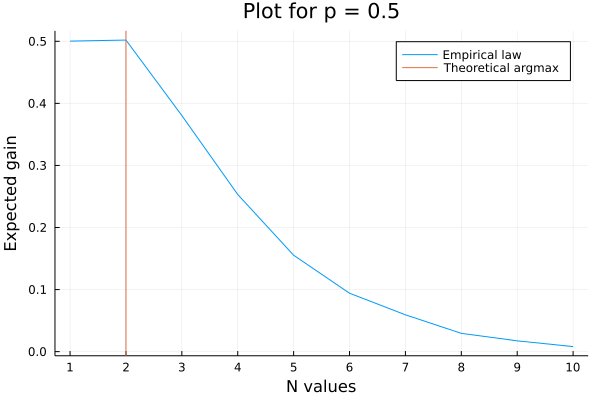

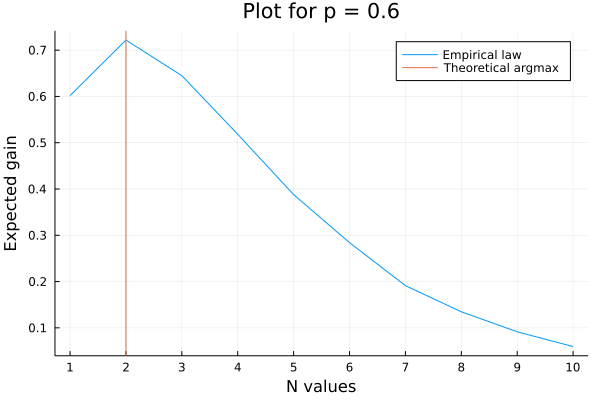

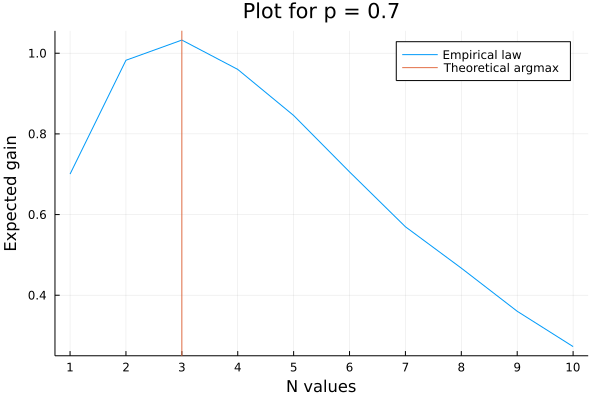

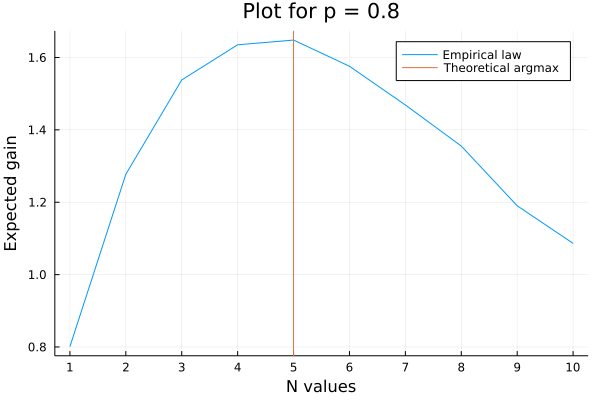

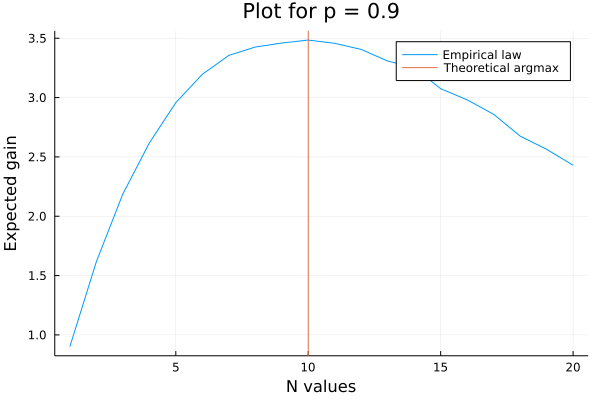

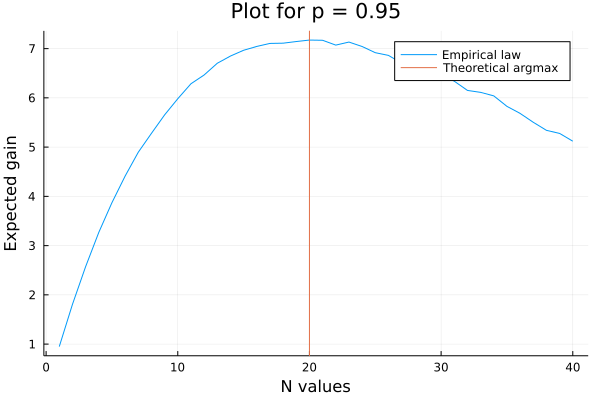

In [52]:
p_values = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

for proba in p_values
    argmax = Int8(ceil(-1/log(proba)))
    N_max = max(10, 2argmax)
    N_values = 1:N_max
    expt_gain = v1_exp_gain.(N_values, [proba;])
    p = plot(N_values, expt_gain, title = "Plot for p = $proba", label = "Empirical law")
    vline!(p, [argmax], label =  "Theoretical argmax")
    if proba < 0.85
        xticks!(p, N_values)
    end
    xlabel!(p, "N values")
    ylabel!(p, "Expected gain")
    display(p)
end